# Gaussian mixture model with Infer.Net and pyMC3

this is an implementation in python of the example https://dotnet.github.io/infer/userguide/Mixture%20of%20Gaussians%20tutorial.html (MixtureOfGaussians.cs in the source code). It's an example of a Gaussian mixture model with two components. 

## Bayesian graphical model in Infer.Net

In [1]:
import sys
sys.path.append(r'../dotNet/libs')

import clr
clr.AddReference("Microsoft.ML.Probabilistic")
clr.AddReference("Microsoft.ML.Probabilistic.Compiler")
clr.AddReference("Microsoft.ML.Probabilistic.Learners")

from System import Array, Double, Int32, Type, Converter
from utils import plot_graph

In [2]:
from Microsoft.ML.Probabilistic.Math import Rand, Vector, PositiveDefiniteMatrix
from Microsoft.ML.Probabilistic.Models import Variable, VariableArray, Range, InferenceEngine
from Microsoft.ML.Probabilistic.Algorithms import VariationalMessagePassing
from Microsoft.ML.Probabilistic.Distributions import Distribution, VectorGaussian, Gaussian, Gamma, Bernoulli, Discrete

In [3]:
# remove all previously generated graph files
!rm -f *.svg *.gv

### Define the mixture components

First we define the components in the mixture model with their priors. A Gaussian mixture model is constructed as a weighted sum of Gaussian distributions. In this case, we will construct a model containing two two-dimensional Gaussian distributions. The mean vector has a Gaussian prior, while the prior for the precision is modeled with a Wishart distribution. The weights are normalized (i.e. they sum to one), such that a two-dimensional Dirichlet distribution is a suitable prior.

In [4]:
# define number of components
k = Range(2).Named('k')

In [5]:
means = Variable.Array[Vector](k).Named('means')
means.set_Item(k, Variable.VectorGaussianFromMeanAndPrecision(
            Vector.FromArray(0.0, 0.0),
            PositiveDefiniteMatrix.IdentityScaledBy(2, 0.01)).ForEach(k))

In [6]:
precisions = Variable.Array[PositiveDefiniteMatrix](k).Named('precisions')
precisions.set_Item(k, Variable.WishartFromShapeAndScale(
    100.0, PositiveDefiniteMatrix.IdentityScaledBy(2, 0.01)).ForEach(k))

In [7]:
weights = Variable.Dirichlet(k, Array[Double]([1.0, 1.0])).Named('weights')

### Define the latent variable and data

For each data point, we associate a random latent variable that selects which component the data point belongs to. Each latent variable is sampled from a discrete distribution (possible values 0 and 1) with probabilities determined by the weights.

In [8]:
# define data range
n = Range(300).Named("n")

In [9]:
# latent (selector) variable
z = Variable.Array[int](n).Named('z')
z.set_Item(n, Variable.Discrete(weights).ForEach(n))

In [10]:
# connect the data samples to the associated mixture component
data = Variable.Array[Vector](n).Named('x')
for_each_block = Variable.ForEach(n)
switch_block = Variable.Switch(z.get_Item(n))
data.set_Item(n, Variable.VectorGaussianFromMeanAndPrecision(
    means.get_Item(z.get_Item(n)), 
    precisions.get_Item(z.get_Item(n))))
switch_block.CloseBlock()
for_each_block.CloseBlock()

### Generate data

The data is generated by random sampling from two Gaussian distributions.

In [11]:
def generate_data(count):
    true_means1 = Vector.FromArray(2.0, 3.0)
    true_means2 = Vector.FromArray(7.0, 5.0)
    
    p1 = Array.CreateInstance(Double, 2, 2)
    p1[0,0] = 3.0; p1[0,1] = 0.2; p1[1,0] = 0.2; p1[1,1] = 2.0
    p2 = Array.CreateInstance(Double, 2, 2)
    p2[0,0] = 2.0; p2[0,1] = 0.4; p2[1,0] = 0.4; p2[1,1] = 4.0
    
    true_precision1 = PositiveDefiniteMatrix(p1)
    true_precision2 = PositiveDefiniteMatrix(p2)
    
    true_distribution1 = VectorGaussian.FromMeanAndPrecision(
                            true_means1, true_precision1)
    true_distribution2 = VectorGaussian.FromMeanAndPrecision(
                            true_means2, true_precision2)
    
    is_component1 = Bernoulli(0.6)

    # Restart the infer.NET random number generator
    Rand.Restart(12347);
    
    data = Array.CreateInstance(Vector, count)
    for i in range(count):
        data[i] = true_distribution1.Sample() if is_component1.Sample() \
            else  true_distribution2.Sample()

    return data

In [12]:
data.ObservedValue = generate_data(n.SizeAsInt)

### Initialize the latent variables

Because the two Gaussian distributions are defined in the same way, they are not distinguishable during the inference update steps if all messages are initialized with uniform distributions. This means that initially half of the observations would be assigned to either one of the component with equal probability. Hence, the message passing would update the marginal for each component as equally likely, which would again update the latent variable with equal probability for each component. To break the symmetry we need to randomly initialize the messages. To see the effect without the random initialization, skip the next cell and run the inference directly.

In [13]:
z_init = Array.CreateInstance(Discrete, n.SizeAsInt)
for i in range(z_init.Length):
    z_init[i] = Discrete.PointMass(Rand.Int(k.SizeAsInt), k.SizeAsInt)
z.InitialiseTo(Distribution[int].Array[Discrete](z_init));

### Run the inference

Compute the marginal (posterior) distributions for the means and precisions of the Gaussian components and their weights.

In [14]:
engine = InferenceEngine(VariationalMessagePassing())
engine.ModelName = 'Gaussian_mixture'
engine.ShowFactorGraph = True

In [15]:
marginal_weights = engine.Infer(weights)
marginal_means = engine.Infer(means)
marginal_precisions = engine.Infer(precisions)

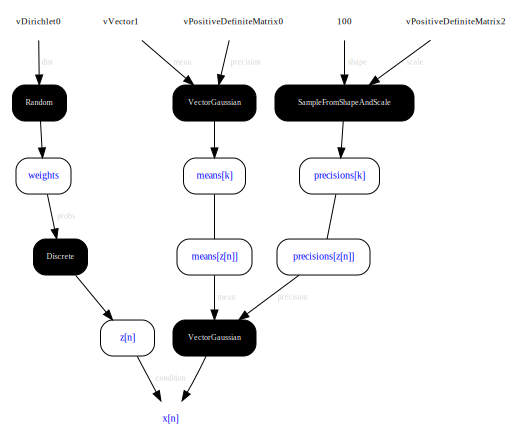

In [16]:
plot_graph(engine.ModelName)

In [17]:
print(f'Dist over weights = {marginal_weights}')
print(f'Dist over means = \n {marginal_means}')
print(f'Dist over precisions= \n {marginal_precisions}')

Dist over weights = Dirichlet(180 122)
Dist over means = 
 [0] VectorGaussian(2.033 2.897, 0.003775   -9.646e-05)
                                -9.646e-05 0.004307  
[1] VectorGaussian(7.041 4.986, 0.006446   -6.828e-05)
                                -6.828e-05 0.00586   
Dist over precisions= 
 [0] Wishart(189.5, 0.007813 0.000175)[mean=1.481   0.03316]
                   0.000175 0.006848       0.03316 1.298  
[1] Wishart(160.5, 0.007988  9.308e-05)[mean=1.282   0.01494]
                   9.308e-05 0.008788        0.01494 1.41   


### Visualize

Let's visualize the data and Gaussian distributions of the mixture that have been inferred. We will visualize the Gaussian as ellipsoids with axes sizes given by two times the standard deviations.

In [18]:
%matplotlib inline
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [19]:
def to_list(data):
    try:
        return [[val for val in d] for d in data]
    except TypeError:
        return [d for d in data]

In [20]:
observations = np.asarray(to_list(data.ObservedValue))

In [21]:
means_points = [np.asarray(to_list(marginal_means.get_Item(i).GetMean())) 
                for i in range(marginal_means.GetLength(0))] 

precisions_points = [np.reshape(to_list(
    marginal_precisions.get_Item(i).GetMean()), (2, 2))
                     for i in range(marginal_precisions.GetLength(0))]
covs_points = [np.linalg.inv(prec) for prec in precisions_points]

covs_shape = []
for cov in covs_points:
    eigen_vals, U = np.linalg.eig(cov)
    angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))
    covs_shape += [{'axes':eigen_vals,'orientation':angle}]

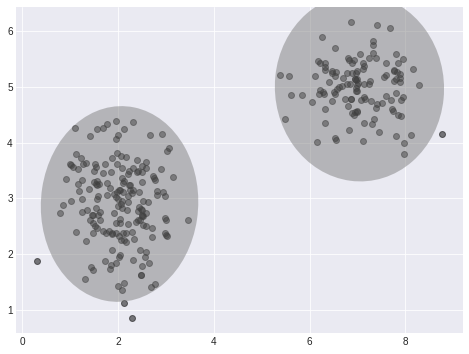

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

for m, shape in zip(means_points, covs_shape):
    ax_sizes = shape['axes']
    angle = shape['orientation']
    # sizes of ellipse need to be defined in diameter
    e = Ellipse(m, 4 * np.sqrt(ax_sizes[0]), 4 * np.sqrt(ax_sizes[1]), angle = -angle)
    e.set_alpha(0.5)
    e.set_facecolor('gray')
    ax.add_artist(e);

ax.scatter(observations[:, 0], observations[:, 1], c='k', alpha=0.5);


## Markov Chain Monte Carlo in pyMC3

Inference of Gaussian mixture model can also be approximated using MCMC sampling. Unfortunately it's not adequate to use the Wishart distribution as prior for the precisions, because it's hard to limit the sampling to positive definite matrices. It's recommended to use LKJ as prior for the correlation matrix and transform the sampled matrix into a coveriance.

**Note**: Breaking the symmetry of mixture components is not as straightforward as in with variational message passing in the Bayesian graph model. Currently there is no easy way to handle this in pyMC3 for multivariate models.

In [23]:
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
import theano.tensor as tt
from theano.tensor.nlinalg import det, matrix_inverse
import numpy as np

env: THEANO_FLAGS=device=cpu,floatX=float32


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [24]:
observations = np.asarray(to_list(data.ObservedValue))

In [25]:
with pm.Model() as model:
    
    means = [pm.MvNormal(f'mean_{i}', mu = np.zeros(2),
                        tau = 0.01 * np.eye(2),
                        shape = 2)
            for i in range(2)]
    
    # using LKJCov
    sigmas = [pm.Lognormal(f'sigma_{i}', np.zeros(2), np.ones(2), shape = 2)
              for i in range(2)]
    
    nu = pm.Uniform('nu', 0, 5) 
    C_uptriangles = [pm.LKJCorr(f'C_uptriangles_{i}', nu, 2) 
                     for i in range(2)]
    
    Cs = [pm.Deterministic(f'C_{i}', tt.fill_diagonal(C_uptriangles[i][np.zeros((2, 2), dtype=np.int64)], 1.))
          for i in range(2)]
    
    sigma_diags = [pm.Deterministic(f'sigma_mat_{i}', tt.nlinalg.diag(sigmas[i]))
                   for i in range(2)]
    
    covs = [pm.Deterministic(f'cov_{i}', tt.nlinalg.matrix_dot(sigma_diags[i], Cs[i], sigma_diags[i]))
            for i in range(2)]
    
    components = [pm.MvNormal.dist(mu = means[i], cov = covs[i])
                  for i in range(2)]
    
    weights = pm.Dirichlet('weights', a = np.ones(2), shape = 2)
    
    mixture = pm.Mixture('mixture', w = weights, comp_dists = components, observed = observations)

In [26]:
with model:
    trace = pm.sample(5000, pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [weights]
>Metropolis: [C_uptriangles_1]
>Metropolis: [C_uptriangles_0]
>Metropolis: [nu]
>Metropolis: [sigma_1]
>Metropolis: [sigma_0]
>Metropolis: [mean_1]
>Metropolis: [mean_0]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:51<00:00, 429.46draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Because the sampling cannot distinguish between the two component, both Gaussian means can sometimes show as solutions in the traces for each mean.

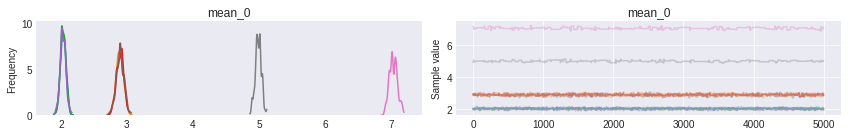

In [27]:
pm.traceplot(trace, varnames=['mean_0']);

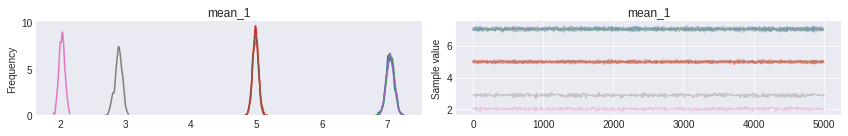

In [28]:
pm.traceplot(trace, varnames=['mean_1']);

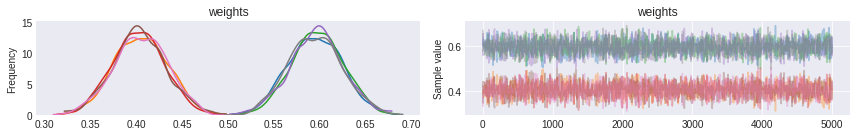

In [29]:
pm.traceplot(trace, varnames=['weights']);

The covariances didn't converge so well. This need some more investigation.

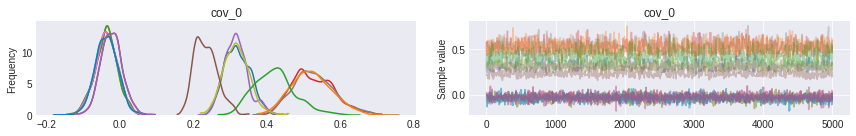

In [30]:
pm.traceplot(trace, varnames=['cov_0']);

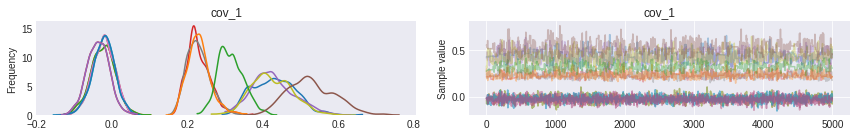

In [31]:
pm.traceplot(trace, varnames=['cov_1']);